In [35]:
import os, sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import DataLoader, random_split
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
import anndata
import pickle

script_dir = Path().resolve()
repo_dir = script_dir
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
sys.path.append(str(src_dir))
sys.path.append(str(data_dir))

from dataset.read_scrnaseq_data import read_cell_by_gene_matrix, convert_cell_by_gene_matrix_to_anndata, read_hires_metadata_file, ensure_same_genes_in_dataframes
from dataset.preprocessing import scrna_seq_normalization
from dataset.dataloader import AnnDataDataset
from dataset.precompute_scrnaseq_data import *

from model.scRNA_AE import scRNASeqAE
from model.scRNA_E_C import scRNASeqE_simCLR, scRNASeqEncoder, scRNASeqDecoder, scRNASeqProjectionHead, scRNASeqE_VICReg, scRNASeqE_VICRegLarge, scRNASeqE_VICRegExpanderLarge, scRNASeqE_VICRegExpander


PARAMETERS = {
    'hvgs': 20116,
    'num_genes': 20116,
    'latent_dimension': 50,
    'target_sum': 10000,
    'batch_size': 1024,
    'num_epochs': 5,
}

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 600
plt.rcParams["figure.figsize"] = (12, 8)

In [10]:
VERSION = 'v3,5'
tm_adata_train_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_train_{VERSION}.pkl'
with open(tm_adata_train_path, 'rb') as f:
    tm_adata_train = pickle.load(f)
tm_adata_train = tm_adata_train.copy()

tm_adata_test_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_test_{VERSION}.pkl'
with open(tm_adata_test_path, 'rb') as f:
    tm_adata_test = pickle.load(f)
tm_adata_test = tm_adata_test.copy()

In [11]:
tm_adata_test

AnnData object with n_obs × n_vars = 61774 × 20116
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p'

In [3]:
from glob import glob

model_checkpoints_paths = glob(r'./multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/*')
model_checkpoints_paths = model_checkpoints_paths[5:10]
model_checkpoints_paths

['./multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/genes20116_batch1024_latent128_fixedloss_seed1_ctCS_ctmsgG_DO_ctRS_gSS_epoch=29-val_loss=12.2890.ckpt',
 './multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/genes20116_batch1024_latent128_fixedloss_seed2_ctCS_ctmsgG_DO_ctRS_gSS_epoch=46-val_loss=11.3437.ckpt',
 './multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/genes20116_batch1024_latent128_fixedloss_seed3_ctCS_ctmsgG_DO_ctRS_gSS_epoch=47-val_loss=11.6886.ckpt',
 './multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/genes20116_batch1024_latent128_fixedloss_seed4_ctCS_ctmsgG_DO_ctRS_gSS_epoch=42-val_loss=12.8508.ckpt',
 './multiseed_experiments/best_trial_results/v3,5/checkpoints/multiseed/genes20116_batch1024_latent128_fixedloss_seed5_ctCS_ctmsgG_DO_ctRS_gSS_epoch=46-val_loss=12.0829.ckpt']

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# representations = {}
embeds= []
for model_checkpoints_path in model_checkpoints_paths:
    seed_num = model_checkpoints_path.split('_seed')[1][0]
    with torch.no_grad():
        VICreg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(model_checkpoints_path)
        VICreg_model.to(device)
        VICreg_model.eval()
        latent_representations = VICreg_model.encoder(
            torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32).to(device)
            )
    # representations[seed_num] = latent_representations
    embeds.append(latent_representations)
    tm_adata_test.obsm[f'X_latent_{seed_num}'] = latent_representations

In [14]:
def cka(A,B):
    A -= A.mean(0,keepdims=True); B -= B.mean(0,keepdims=True)
    hsic = torch.sum((A.T@B)**2)
    return hsic / torch.sqrt(torch.sum((A.T@A)**2)*torch.sum((B.T@B)**2))

In [16]:
M = len(embeds)
S = np.zeros((M, M))
for i in range(M):
    for j in range(i, M):
        s = cka(embeds[i], embeds[j])
        S[i,j] = S[j,i] = s.item()


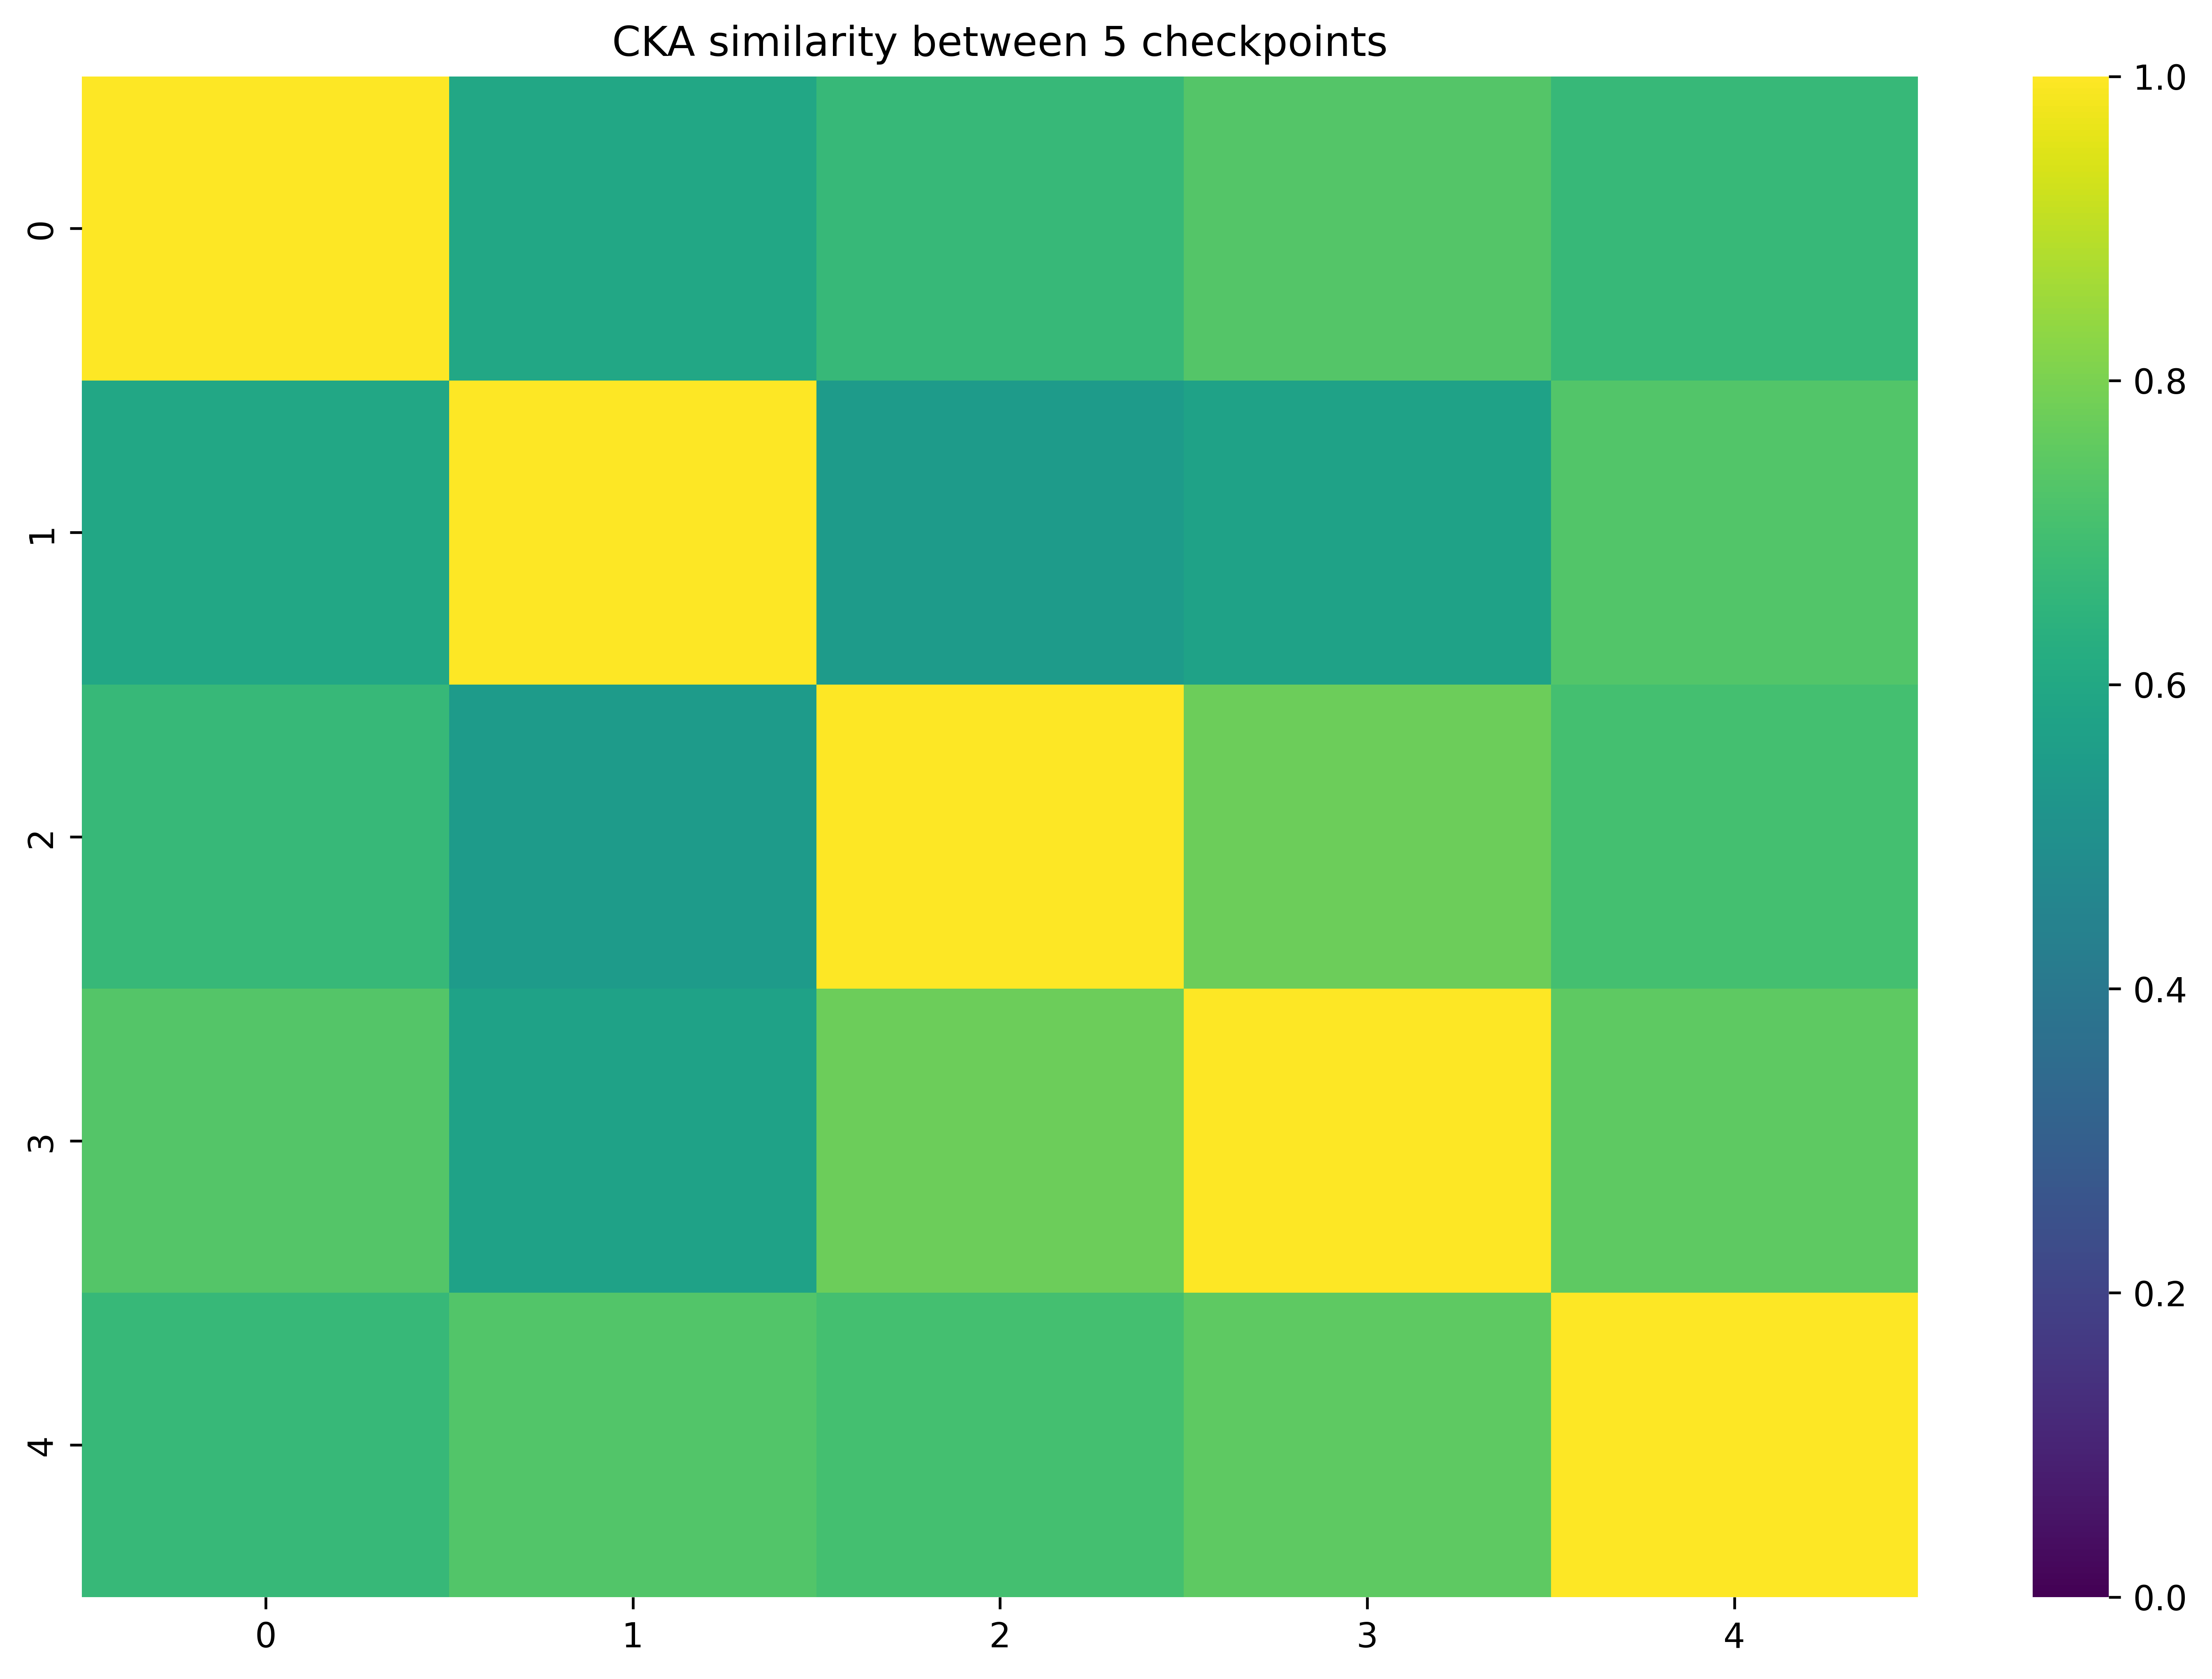

In [19]:
import matplotlib.pyplot as plt, seaborn as sns
sns.heatmap(S, vmin=0, vmax=1, cmap="viridis")
plt.title("CKA similarity between 5 checkpoints")
plt.show()

In [27]:
import numpy as np, torch, itertools, pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from scipy.linalg import orthogonal_procrustes, svd
from scipy.spatial.distance import pdist, squareform
from tqdm.auto import tqdm

# ------------------------------------------------------------
# helpers
# ------------------------------------------------------------
def to_np(x):                      # torch → numpy (2‑D  [cells × dim])
    return x.detach().cpu().float().numpy()

def cka_linear(A, B):
    """Centered Kernel Alignment (linear)."""
    A, B = A - A.mean(0, keepdims=True), B - B.mean(0, keepdims=True)
    hsic  = np.linalg.norm(A.T @ B, 'fro') ** 2
    varA  = np.linalg.norm(A.T @ A, 'fro') ** 2
    varB  = np.linalg.norm(B.T @ B, 'fro') ** 2
    return hsic / np.sqrt(varA * varB)

def svcca(A, B, var_keep=0.99, center=True):
    """
    Singular‑Vector CCA between two representation matrices.

    A, B : (n_samples × n_features)  numpy arrays
    var_keep : fraction of variance to retain in the PCA step
    returns  : mean canonical correlation  ∈  [0, 1]
    """
    if center:
        A = A - A.mean(0, keepdims=True)
        B = B - B.mean(0, keepdims=True)

    # ----- 1.  PCA compression ------------------------------------------------
    pca_A = PCA(n_components=var_keep, svd_solver='full').fit(A)
    pca_B = PCA(n_components=var_keep, svd_solver='full').fit(B)

    A_ = pca_A.transform(A).T          # shape  dA × N
    B_ = pca_B.transform(B).T          # shape  dB × N

    # ----- 2.  compute covariance matrices -----------------------------------
    # columns are samples → rows are PCs
    Sigma_aa = A_ @ A_.T    # dA × dA
    Sigma_bb = B_ @ B_.T    # dB × dB
    Sigma_ab = A_ @ B_.T    # dA × dB

    # ----- 3.  whitening ------------------------------------------------------
    # eigen‑decompose to get inverse square‑root
    def inv_sqrtm(mat, eps=1e-10):
        U, s, _ = svd(mat)
        return U @ np.diag(1.0 / np.sqrt(s + eps)) @ U.T

    Sigma_aa_inv_sqrt = inv_sqrtm(Sigma_aa)
    Sigma_bb_inv_sqrt = inv_sqrtm(Sigma_bb)

    T = Sigma_aa_inv_sqrt @ Sigma_ab @ Sigma_bb_inv_sqrt   # correlation matrix
    _, s, _ = svd(T)                                       # canonical corr. coeffs

    return s.mean()                                        # 0 ⇢ orthogonal, 1 ⇢ identical


def procrustes_rmse(A, B):
    R, _ = orthogonal_procrustes(A, B)
    diff = A @ R - B
    return np.sqrt((diff**2).mean())

def knn_jaccard(A, B, k=30):
    nbrsA = NearestNeighbors(n_neighbors=k+1).fit(A).kneighbors(A, return_distance=False)[:,1:]
    nbrsB = NearestNeighbors(n_neighbors=k+1).fit(B).kneighbors(B, return_distance=False)[:,1:]
    intersect = np.array([len(set(a).intersection(b)) for a, b in zip(nbrsA, nbrsB)])
    return intersect.mean() / k

# ------------------------------------------------------------
# load all embeddings into a list of numpy arrays
# ------------------------------------------------------------
reprs = [to_np(z) for z in embeds]                 # list length = n_models
names = [f"m{i}" for i in range(len(reprs))]       # labels for DataFrame

n = len(reprs)
cka_mat, svcca_mat, proc_mat, jacc_mat = (np.zeros((n,n)) for _ in range(4))

for (i,j) in tqdm(list(itertools.combinations_with_replacement(range(n), 2))):
    A, B = reprs[i], reprs[j]
    cka   = cka_linear(A, B)
    # print('calculated cka')
    sv    = svcca(A, B)
    # print('calculated svcca')
    pr    = procrustes_rmse(A, B)
    # print('calculated procrustes')
    # jac   = knn_jaccard(A, B, k=30)
    # print('calculated knn_jaccard')

    cka_mat[i,j] = cka_mat[j,i] = cka
    svcca_mat[i,j] = svcca_mat[j,i] = sv
    proc_mat[i,j] = proc_mat[j,i] = pr   # lower is better
    # jacc_mat[i,j] = jacc_mat[j,i] = jac

# ------------------------------------------------------------
# pretty print as pandas DataFrames
# ------------------------------------------------------------
metrics = {
    "CKA":   pd.DataFrame(cka_mat,  index=names, columns=names),
    "SVCCA": pd.DataFrame(svcca_mat,index=names, columns=names),
    "Procrustes_RMSE": pd.DataFrame(proc_mat,index=names, columns=names),
    # "kNN_Jaccard": pd.DataFrame(jacc_mat,index=names, columns=names),
}

for k, df in metrics.items():
    print(f"\n{k}\n", df.round(3))


  0%|          | 0/15 [00:00<?, ?it/s]


CKA
        m0     m1     m2     m3     m4
m0  1.000  0.597  0.671  0.734  0.672
m1  0.597  1.000  0.544  0.578  0.728
m2  0.671  0.544  1.000  0.775  0.702
m3  0.734  0.578  0.775  1.000  0.752
m4  0.672  0.728  0.702  0.752  1.000

SVCCA
        m0     m1     m2     m3     m4
m0  1.000  0.521  0.508  0.513  0.537
m1  0.521  1.000  0.503  0.513  0.522
m2  0.508  0.503  1.000  0.516  0.517
m3  0.513  0.513  0.516  1.000  0.529
m4  0.537  0.522  0.517  0.529  1.000

Procrustes_RMSE
        m0     m1     m2     m3     m4
m0  0.000  0.276  0.280  0.256  0.272
m1  0.276  0.000  0.285  0.283  0.259
m2  0.280  0.285  0.000  0.240  0.258
m3  0.256  0.283  0.240  0.000  0.251
m4  0.272  0.259  0.258  0.251  0.000


<Axes: >

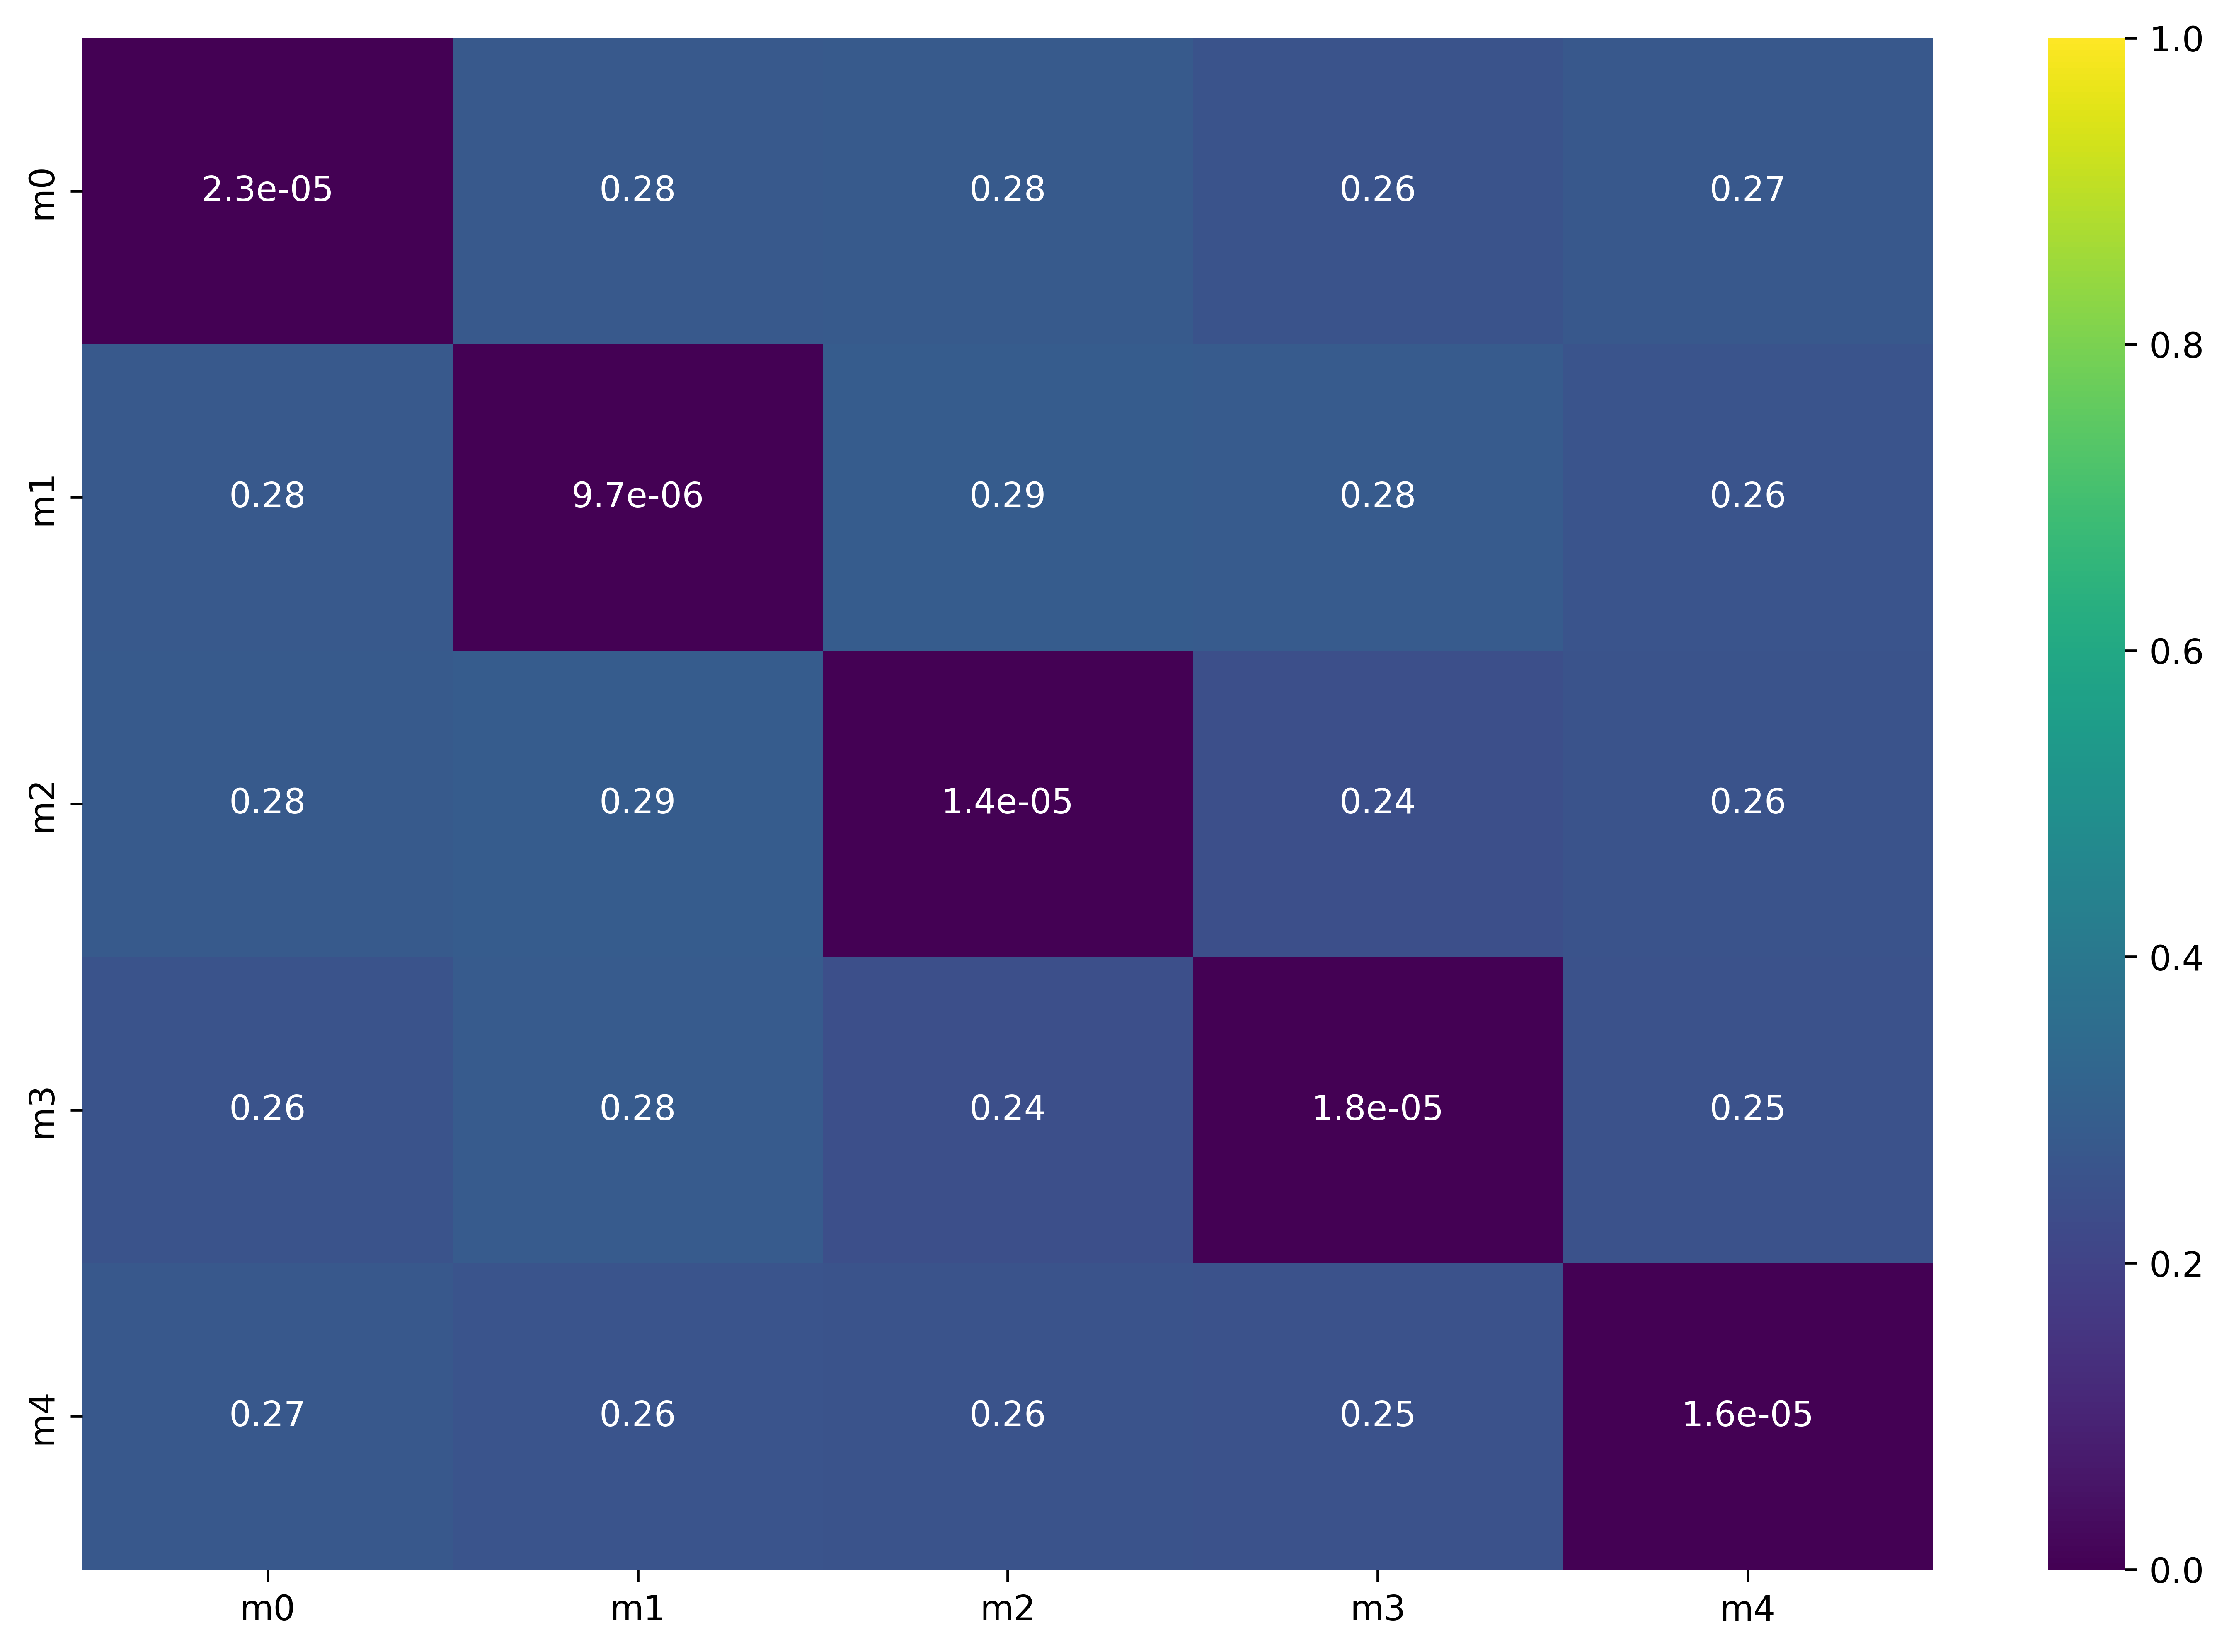

In [57]:
sns.heatmap(metrics["Procrustes_RMSE"], vmin=0, vmax=1, cmap="viridis", annot=True)

### From JHU

In [33]:
sys.path

['/usr/lib64/python39.zip',
 '/usr/lib64/python3.9',
 '/usr/lib64/python3.9/lib-dynload',
 '',
 '/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages',
 '/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib/python3.9/site-packages',
 '/tmp/tmpeqruswke',
 '/oscar/data/rsingh47/wli115/scContrast/src',
 '/oscar/data/rsingh47/wli115/scContrast/data',
 PosixPath('/oscar/data/rsingh47/wli115/scContrast/vae_stability'),
 PosixPath('/oscar/data/rsingh47/wli115/scContrast/multiseed_experiments/vae_stability'),
 PosixPath('/oscar/data/rsingh47/wli115/scContrast/multiseed_experiments/vae_stability')]

In [46]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torch import Tensor

import scanpy as sc

from sklearn.metrics import mean_squared_error

# package_path = "/home/boris/haxx/vae_only/"


import sys
sys.path.append(str(repo_dir / 'multiseed_experiments'))

# from vae_external import VanillaVAE

from vae_stability.utils import double_agg,single_agg
from vae_stability.utils import concordance_plot

from os.path import join as path_join
import os


plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.aspect'] = 'auto'


In [ ]:
joint = []
for i,embed in enumerate(embeds):
    embed = to_np(embed)

    # ensemble_member_names = os.listdir(ensemble_path)
    # ensemble_member_paths = [path_join(ensemble_path,enm) for enm in ensemble_member_names if ".param" not in enm]
    # ensemble_member_paths

    # joint = []
    # for path in ensemble_member_paths:
        # model = VanillaVAE.load(path) 
        # res = model.embeddings(Tensor(extract_validation))
        # joint.append(res['means'].detach().numpy())
    joint.append(embed)
    
    joint = np.concatenate(joint,axis=1)
    joint.shape

    try:
        concordance_plot(joint,joint,plot_text=False,agglomerate=True,metric='correlation',
                        #  path=path_join(model_path,f"ensemble_{e_i}.png")
                         )
    except ValueError:
        print(f"Failed embed {i}")
        continue

ValueError: zero-dimensional arrays cannot be concatenated

joint matrix shape: (61774, 640)
(1280, 1280)


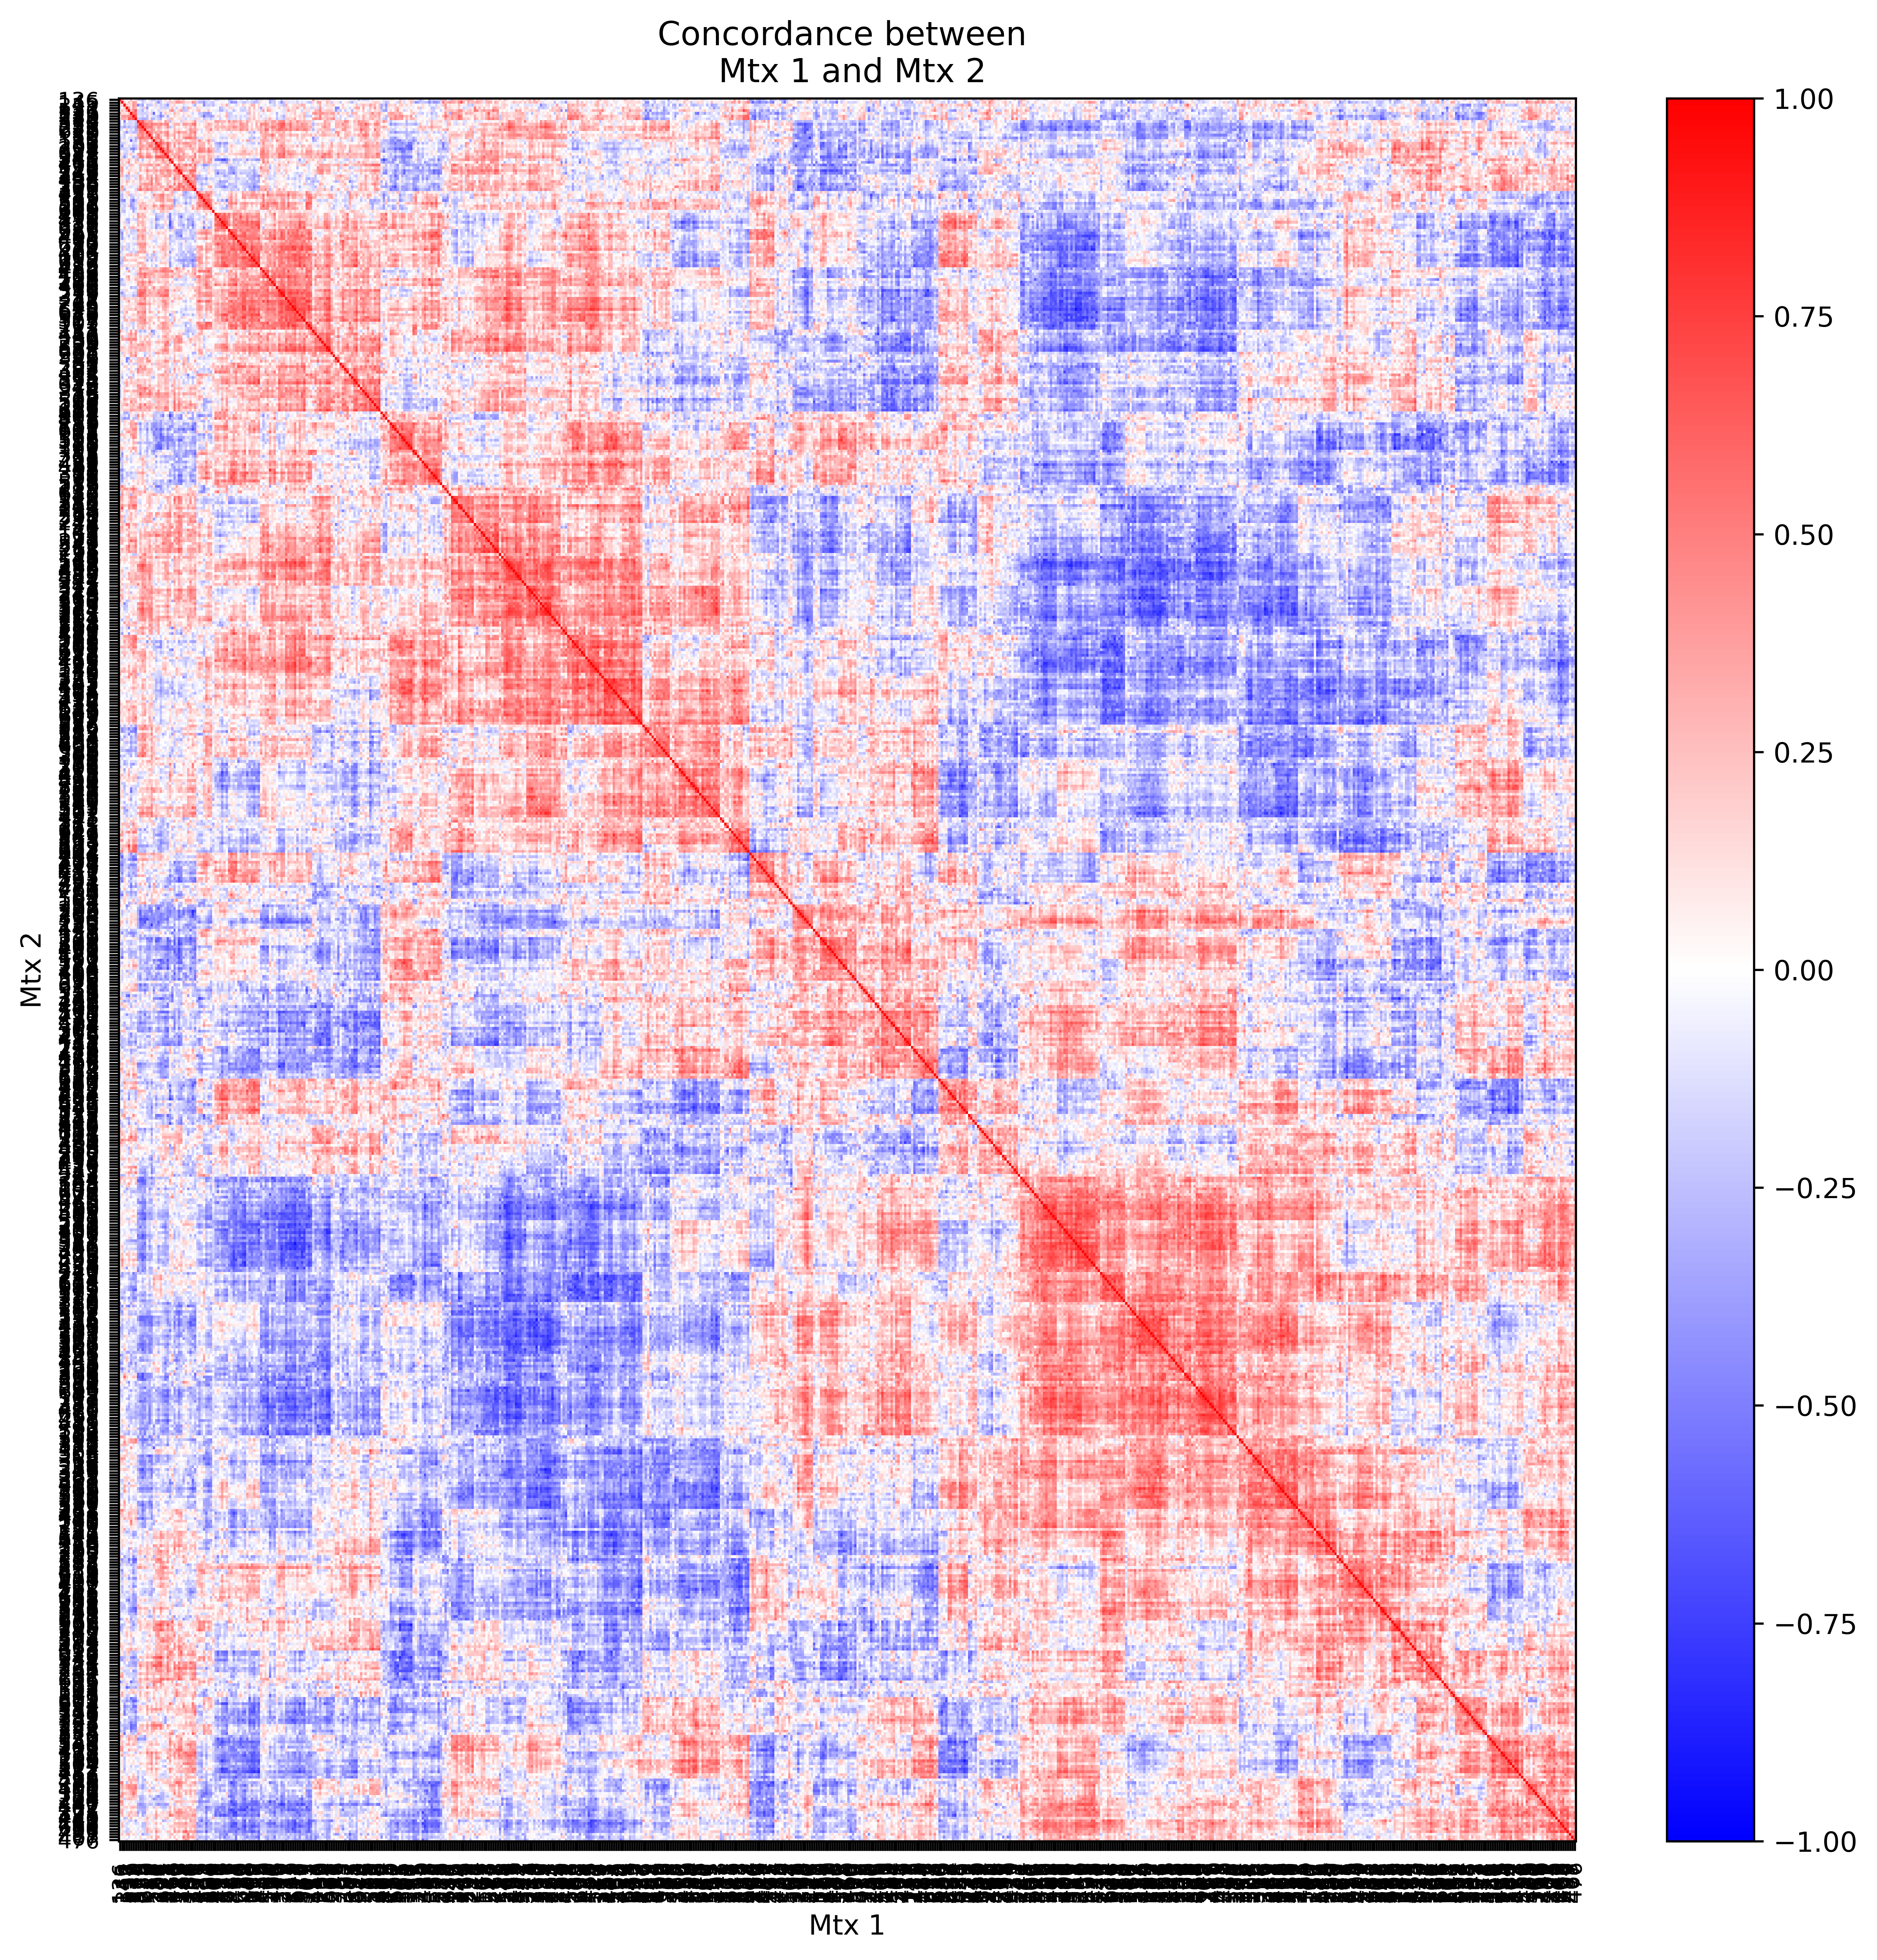

array([[ 1.        ,  0.21854643,  0.22622605, ...,  0.09314008,
         0.15662622, -0.30507375],
       [ 0.21854643,  1.        ,  0.15293924, ...,  0.07620432,
        -0.27517561, -0.35323408],
       [ 0.22622605,  0.15293924,  1.        , ..., -0.09184679,
        -0.2205642 , -0.47158692],
       ...,
       [ 0.09314008,  0.07620432, -0.09184679, ...,  1.        ,
        -0.1059238 ,  0.02954765],
       [ 0.15662622, -0.27517561, -0.2205642 , ..., -0.1059238 ,
         1.        ,  0.43685729],
       [-0.30507375, -0.35323408, -0.47158692, ...,  0.02954765,
         0.43685729,  1.        ]])

In [53]:
import numpy as np
import torch
from vae_stability.utils import concordance_plot   # already on sys.path

# ------------------------------------------------------------------
# 1.  build the joint matrix   (N_cells × [5 · latent_dim])
# ------------------------------------------------------------------
joint = np.concatenate(
    [emb.cpu().detach().numpy() if isinstance(emb, torch.Tensor) else emb
     for emb in embeds],
    axis=1
)

print("joint matrix shape:", joint.shape)   # e.g. (20_000, 5*20)

# ------------------------------------------------------------------
# 2.  draw the concordance heat‑map
# ------------------------------------------------------------------
concordance_plot(
    joint, joint,
    plot_text=False,
    agglomerate=True,
    metric='correlation',
    path="vae_seed_concordance.png"          # omit ‘path=…’ to just display
)
